# IMPORT PACKAGES

In [1]:
import glob
import pandas as pd
import math
import glob
import pandas as pd
import numpy as np
from pandas import DataFrame
from numpy import matrix 
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn import svm
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
import joblib
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,f1_score,recall_score,precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
import joblib
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,f1_score,recall_score,precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn import model_selection
from sklearn import svm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,  precision_score, recall_score, classification_report, confusion_matrix
import sklearn.metrics
import multiprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import warnings

# DEFINE MODEL (FITNESS FUNCTION)

In [2]:
# Created by: Caroline Alves (https://github.com/Carol180619) # Modified 

warnings.filterwarnings("ignore")

def evaluate_model(model, X, y):
    skf       = StratifiedKFold(n_splits=10)
    recall    = []
    precision = []
    f         = []
    accuracy  = []
    roc       = []

    for train_index, test_index in skf.split(X, y):
        xtr, xvl = X.loc[train_index], X.loc[test_index]
        ytr, yvl = y.loc[train_index], y.loc[test_index]

        ytr = ytr.to_numpy().reshape(len(ytr),)
        model.fit(xtr, ytr)

        y_pred = model.predict(xvl)

        yvl = yvl.to_numpy().reshape(len(yvl),)
        n_classes = len(np.unique(yvl))
        yvl1 = label_binarize(yvl, classes=np.arange(n_classes))
        y_pred1 = label_binarize(y_pred, classes=np.arange(n_classes))

        roc.append(roc_auc_score(yvl, y_pred))
        accuracy.append(accuracy_score(yvl, y_pred))
        recall.append(recall_score(yvl, y_pred))
        precision.append(precision_score(yvl, y_pred, average='weighted'))
        f.append(sklearn.metrics.f1_score(yvl, y_pred, average='weighted'))

    return (np.mean(roc), np.std(roc), np.mean(accuracy), np.std(accuracy),
            np.mean(recall), np.std(recall), np.mean(precision), np.std(precision))

def parallel_evaluate(model_name, X_train, y_train):
    if model_name == 'RF':
        model = RandomForestClassifier(n_estimators=100, random_state=1234)
    elif model_name == 'SVM':
        model = SVC(kernel='rbf', gamma=0.1, C=1, probability=True, random_state=1234)
    elif model_name == 'NB':
        model = GaussianNB(var_smoothing=1e-9)
    elif model_name == 'MLP':
        model = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', solver='adam', learning_rate='constant', random_state=1234)
    elif model_name == 'KNN':
        model = KNeighborsClassifier(n_neighbors=5, leaf_size=30, p=2, weights='uniform', metric='minkowski')
    elif model_name == 'LR':
        model = LogisticRegression(C=1.0, penalty='l2', random_state=1234)

    roc_mean, std_roc, accuracy_mean, std_accuracy, recall_mean, std_recall, precision_mean, std_precision = evaluate_model(model, X_train, y_train)

    return {
        'Model': model_name,
        'AUC': roc_mean,
        'AUC std': std_roc,
        'Accuracy': accuracy_mean,
        'Accuracy std': std_accuracy,
        'Recall': recall_mean,
        'Recall std': std_recall,
        'Precision': precision_mean,
        'Precision std': std_precision
    }

# DATA WITH SELECTED FEATURES (AUX FITNESS FUNCTION)

In [3]:
def fitness_function(position, X_train, y_train,convergence_curve):
    rounded_position = []
    reduced_X_train  = []
    results          = []
    
    # Arredonda os valores em position    
    rounded_position = np.where(position < 0.5, 0, 1)
        
    # Filtra as colunas de X_train com base em rounded_position
    reduced_X_train = X_train[:, rounded_position == 1]
   
    # Novo conjunto serve de entrada para função fitness
    reduced_X_train = pd.DataFrame(reduced_X_train)
    y_train = pd.DataFrame(y_train)
    
    # Avalia conjunto de dados apenas com os atributos selecionados
    results = parallel_evaluate('LR', reduced_X_train, y_train)
    
    # Guarda resultado de cada indivíduo
    convergence_curve.append(results)
    
    # Salva acurácia
    accuracy = results['AUC']
    
    print("Indivíduo: ",rounded_position,"AUC: ",accuracy*100,"%")
    
    # Retorna acurácia e convergence_curve ao PSO
    return accuracy, convergence_curve

# CROW SEARCH ALGORITHM (CSA)

In [4]:
import numpy as np

class Crow:
    def __init__(self, dimensions, bounds):
        self.position = np.random.uniform(bounds[0], bounds[1], dimensions)
        self.memory = np.copy(self.position)
        self.fitness = float('-inf')  # Inicializa com infinito para problemas de minimização

    def update_position(self, target_position, fl, AP, bounds):
        if np.random.rand() > AP:
            self.position = self.position + fl * np.random.rand() * (target_position - self.position)
        else:
            self.position = np.random.uniform(bounds[0], bounds[1], len(self.position))
        self.position = np.clip(self.position, bounds[0], bounds[1])

def crow_search_algorithm(dimensions, num_crows, max_iterations, bounds, AP, fl, X_train, y_train,convergence_curve):
    crows = [Crow(dimensions, bounds) for _ in range(num_crows)]
    global_best_value = float('-inf')
    global_best_position = None

    for iter in range(max_iterations):
        print("\nIteração: ",iter)
        for crow in crows:
            current_fitness, convergence_curve = fitness_function(crow.position, X_train, y_train,convergence_curve)
            if current_fitness > crow.fitness:  # Atualiza se a nova posição é melhor
                crow.memory = np.copy(crow.position)
                crow.fitness = current_fitness

        # Encontrar a melhor memória entre todos os corvos
        best_crow = max(crows, key=lambda c: c.fitness)
        if best_crow.fitness > global_best_value:
            global_best_value = best_crow.fitness
            global_best_position = np.copy(best_crow.memory)

        # Atualizar posições
        for crow in crows:
            target_position = crows[np.random.randint(num_crows)].memory
            crow.update_position(target_position, fl, AP, bounds)

    return global_best_position, global_best_value, convergence_curve



# READ DATA

In [5]:
healthy_spearman= [pd.read_csv(n,sep=",", index_col=False,header=None) for n in glob.glob(r'spearman-hc/*csv')]
autism_spearman= [pd.read_csv(n,sep=",", index_col=False,header=None) for n in glob.glob(r'spearman-asd/*csv')]

# FLATTEN 

In [6]:
list_replace_healthy=[]
list_flatten_healthy=[]
def flatten_matrix(x):
    test1 = np.array(x)
    flatten= matrix.flatten(test1)
    return flatten[0:15000]

for i in healthy_spearman:
    list_replace_healthy.append(np.nan_to_num(i))
  
     
for i in list_replace_healthy:
    list_flatten_healthy.append(flatten_matrix(i))

print(len(list_replace_healthy))
print(len(list_flatten_healthy))


list_replace_disease=[]
list_flatten_disease=[]
for i in autism_spearman:
    list_replace_disease.append(np.nan_to_num(i))
     
for i in list_replace_disease:
    list_flatten_disease.append(flatten_matrix(i))
print(len(list_replace_disease))
print(len(list_flatten_disease))

258
258
242
242


# LABELS

In [7]:
yes_label = [1]*len(list_flatten_disease)
no_label = [0]*len(list_flatten_healthy)

labels = yes_label + no_label
#
print(len(labels))
y=np.nan_to_num(labels)

500


# SPLITING AND  STANDARDIZATION

In [8]:
myScaler = preprocessing.StandardScaler()
X= np.concatenate([list_flatten_disease,list_flatten_healthy],axis=0)
X = myScaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, shuffle=True, 
    random_state = 1234)
X_train= np.nan_to_num(X_train)

X_test= np.nan_to_num(X_test)
print(np.shape(X_train))
print(np.shape(X_test))

(375, 14884)
(125, 14884)


# RUN CSA

In [9]:
# Executar CSA
print("TRAIN SET PERFORMANCE\n")
dimensions = X_train.shape[1]  # Número de dimensões
num_crows =                30  # Tamanho da população
max_iterations =          100  # Número máximo de gerações (iterações)
bounds =               (0, 1)  # Limites para as posições dos corvos
AP =                      0.1
fl =                        2
convergence_curve =        []
# Executando o algoritmo
best_position, best_value, convergence_curve = crow_search_algorithm(dimensions, num_crows, max_iterations, bounds, AP, fl, X_train, y_train,convergence_curve )

print("\nMelhor posição:", best_position)
print("\nMelhor fitness:", best_value)

TRAIN SET PERFORMANCE


Iteração:  0
Indivíduo:  [0 1 1 ... 1 1 0] AUC:  64.87573099415205 %
Indivíduo:  [1 0 1 ... 1 0 1] AUC:  64.66959064327486 %
Indivíduo:  [1 0 0 ... 0 0 0] AUC:  64.6842105263158 %
Indivíduo:  [0 1 0 ... 1 1 1] AUC:  65.23684210526315 %
Indivíduo:  [0 1 0 ... 1 0 0] AUC:  64.94444444444444 %
Indivíduo:  [0 1 0 ... 0 1 0] AUC:  64.94736842105262 %
Indivíduo:  [0 1 0 ... 0 0 1] AUC:  65.08479532163743 %
Indivíduo:  [0 0 1 ... 1 0 1] AUC:  64.46198830409357 %
Indivíduo:  [1 1 1 ... 1 1 1] AUC:  62.83625730994152 %
Indivíduo:  [0 1 0 ... 0 1 0] AUC:  63.324561403508774 %
Indivíduo:  [1 1 1 ... 1 1 1] AUC:  65.44590643274853 %
Indivíduo:  [0 0 0 ... 0 1 1] AUC:  64.6842105263158 %
Indivíduo:  [0 1 0 ... 0 1 1] AUC:  63.864035087719294 %
Indivíduo:  [1 1 1 ... 0 0 0] AUC:  65.9985380116959 %
Indivíduo:  [1 0 0 ... 1 1 1] AUC:  64.47368421052632 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  64.69736842105263 %
Indivíduo:  [0 0 1 ... 1 1 1] AUC:  63.34941520467836 %
Indivíduo:  

Indivíduo:  [1 1 1 ... 1 0 1] AUC:  64.14181286549707 %
Indivíduo:  [1 1 1 ... 0 0 1] AUC:  64.39327485380117 %
Indivíduo:  [1 0 0 ... 1 0 0] AUC:  64.06140350877193 %
Indivíduo:  [1 1 1 ... 1 1 1] AUC:  65.48830409356727 %
Indivíduo:  [1 1 1 ... 0 0 0] AUC:  65.16520467836257 %

Iteração:  5
Indivíduo:  [1 0 1 ... 1 0 1] AUC:  65.1827485380117 %
Indivíduo:  [1 0 0 ... 0 1 1] AUC:  67.62426900584796 %
Indivíduo:  [1 1 1 ... 1 0 1] AUC:  64.94883040935673 %
Indivíduo:  [0 1 0 ... 1 0 0] AUC:  64.64035087719299 %
Indivíduo:  [0 1 0 ... 0 0 1] AUC:  62.9751461988304 %
Indivíduo:  [0 1 0 ... 0 1 0] AUC:  64.87426900584795 %
Indivíduo:  [0 0 1 ... 0 1 0] AUC:  64.62865497076022 %
Indivíduo:  [1 0 0 ... 1 1 0] AUC:  64.9751461988304 %
Indivíduo:  [0 1 0 ... 0 1 0] AUC:  65.41520467836257 %
Indivíduo:  [1 1 1 ... 0 0 0] AUC:  65.44444444444444 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.64035087719299 %
Indivíduo:  [1 1 1 ... 1 0 1] AUC:  63.55847953216374 %
Indivíduo:  [1 0 0 ... 0 1 1] AUC:  6

Indivíduo:  [0 0 0 ... 0 1 0] AUC:  65.93128654970761 %
Indivíduo:  [0 0 0 ... 0 1 1] AUC:  65.77777777777779 %
Indivíduo:  [0 0 0 ... 0 1 0] AUC:  65.99999999999999 %
Indivíduo:  [0 0 0 ... 0 1 0] AUC:  64.8611111111111 %
Indivíduo:  [1 0 1 ... 1 0 0] AUC:  66.84941520467837 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.81871345029239 %
Indivíduo:  [1 1 1 ... 0 1 1] AUC:  65.43128654970761 %
Indivíduo:  [1 0 0 ... 0 1 1] AUC:  64.74122807017544 %
Indivíduo:  [1 1 1 ... 1 1 1] AUC:  64.62865497076022 %

Iteração:  10
Indivíduo:  [0 0 0 ... 0 1 0] AUC:  65.99999999999999 %
Indivíduo:  [1 0 1 ... 1 1 1] AUC:  65.40350877192984 %
Indivíduo:  [0 0 0 ... 0 1 0] AUC:  65.22222222222223 %
Indivíduo:  [0 1 0 ... 0 1 0] AUC:  65.73684210526316 %
Indivíduo:  [1 1 0 ... 1 0 0] AUC:  66.58479532163743 %
Indivíduo:  [1 0 1 ... 1 0 1] AUC:  65.47222222222221 %
Indivíduo:  [1 0 1 ... 1 1 1] AUC:  68.16666666666667 %
Indivíduo:  [1 0 0 ... 1 1 0] AUC:  66.54239766081871 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:

Indivíduo:  [1 0 1 ... 1 0 0] AUC:  65.01608187134502 %
Indivíduo:  [1 0 0 ... 1 1 1] AUC:  67.93128654970761 %
Indivíduo:  [1 0 1 ... 0 1 1] AUC:  66.27923976608187 %
Indivíduo:  [1 0 0 ... 1 0 0] AUC:  66.05847953216374 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.27923976608187 %
Indivíduo:  [0 0 0 ... 1 1 1] AUC:  65.76461988304094 %
Indivíduo:  [0 0 0 ... 1 0 1] AUC:  67.07017543859648 %
Indivíduo:  [1 1 1 ... 1 0 1] AUC:  66.20760233918128 %
Indivíduo:  [1 1 0 ... 1 1 1] AUC:  66.5701754385965 %
Indivíduo:  [0 0 0 ... 0 1 1] AUC:  66.80555555555556 %
Indivíduo:  [1 0 1 ... 1 0 0] AUC:  66.29239766081871 %
Indivíduo:  [0 0 0 ... 0 1 1] AUC:  66.76315789473684 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.47222222222223 %

Iteração:  15
Indivíduo:  [0 0 0 ... 0 1 1] AUC:  65.19444444444444 %
Indivíduo:  [1 1 1 ... 0 0 1] AUC:  66.58625730994152 %
Indivíduo:  [0 1 1 ... 1 0 1] AUC:  67.5687134502924 %
Indivíduo:  [1 1 1 ... 0 0 0] AUC:  65.69736842105263 %
Indivíduo:  [1 1 1 ... 1 1 1] AUC: 

Indivíduo:  [1 0 0 ... 1 0 0] AUC:  64.94444444444444 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.54239766081872 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.86111111111111 %
Indivíduo:  [0 0 0 ... 1 0 1] AUC:  65.47222222222221 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.16520467836258 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.24853801169591 %
Indivíduo:  [0 1 1 ... 1 1 1] AUC:  65.40497076023392 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.15350877192982 %
Indivíduo:  [0 0 0 ... 1 1 0] AUC:  63.38011695906434 %
Indivíduo:  [1 0 1 ... 1 1 1] AUC:  67.04385964912281 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.26608187134502 %
Indivíduo:  [1 0 0 ... 0 1 1] AUC:  66.30701754385966 %
Indivíduo:  [1 0 1 ... 1 1 1] AUC:  64.8640350877193 %
Indivíduo:  [0 0 0 ... 1 0 1] AUC:  65.78070175438596 %
Indivíduo:  [0 0 0 ... 1 0 1] AUC:  65.52923976608186 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.90058479532163 %
Indivíduo:  [1 0 0 ... 1 1 1] AUC:  65.76754385964912 %

Iteração:  20
Indivíduo:  [1 1 1 ... 1 0 0] AUC:

Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.21052631578947 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.59795321637426 %
Indivíduo:  [1 1 1 ... 1 0 1] AUC:  66.02777777777777 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.65204678362574 %
Indivíduo:  [1 1 1 ... 1 0 1] AUC:  65.71052631578948 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.66812865497077 %
Indivíduo:  [1 0 1 ... 0 1 0] AUC:  65.44590643274853 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.80701754385964 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.87573099415205 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  65.98684210526316 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.0014619883041 %
Indivíduo:  [1 1 0 ... 1 0 1] AUC:  66.2938596491228 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.83479532163742 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.30701754385964 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.34795321637425 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.83479532163742 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.59941520467837 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.81871345029

Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.83479532163743 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.42982456140352 %
Indivíduo:  [0 1 1 ... 1 0 1] AUC:  67.62426900584796 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  65.46052631578948 %
Indivíduo:  [1 1 1 ... 1 0 1] AUC:  67.0701754385965 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.82017543859648 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.32163742690058 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.87573099415205 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.11111111111113 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.83333333333333 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.0029239766082 %
Indivíduo:  [1 1 0 ... 1 0 1] AUC:  64.46345029239767 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.80847953216376 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.57163742690058 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.77777777777777 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.2923976608187 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.55701754385966 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.583333333333

Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.6125730994152 %
Indivíduo:  [1 1 1 ... 1 0 1] AUC:  64.54532163742691 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.54385964912282 %
Indivíduo:  [1 1 1 ... 1 0 1] AUC:  65.22368421052632 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.54385964912282 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  65.97514619883042 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  64.5877192982456 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.08625730994152 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.66666666666667 %
Indivíduo:  [1 1 1 ... 1 1 0] AUC:  67.76315789473685 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.11111111111113 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.5701754385965 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.38888888888887 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.41666666666667 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  65.94590643274853 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  65.22368421052632 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.05701754385964 %
Indivíduo:  [1 1 0 ... 1 0 1] AUC:  65.988304093567

Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.1798245614035 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.84795321637426 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.84941520467835 %

Iteração:  39
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.84795321637426 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.90350877192982 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.08479532163743 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.09941520467837 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.65204678362574 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.04239766081871 %
Indivíduo:  [1 1 0 ... 1 0 1] AUC:  64.17105263157895 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.38888888888889 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.12573099415205 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.90204678362574 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.84795321637426 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.87573099415205 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.55701754385966 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.30701754385964 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:

Indivíduo:  [1 1 1 ... 1 0 0] AUC:  63.34941520467836 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.93128654970762 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.94444444444444 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.12573099415205 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.05701754385966 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.42982456140352 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.59795321637428 %

Iteração:  44
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.59649122807018 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.37573099415205 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  69.20760233918129 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.65497076023392 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.91666666666667 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.20906432748536 %
Indivíduo:  [0 0 1 ... 1 0 0] AUC:  66.23830409356725 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.01608187134502 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.17836257309942 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.95760233918129 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC

Indivíduo:  [0 1 1 ... 0 0 1] AUC:  65.69444444444444 %
Indivíduo:  [1 1 1 ... 0 0 0] AUC:  65.96052631578948 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.57017543859648 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.90350877192984 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.87573099415205 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.19444444444443 %
Indivíduo:  [0 1 0 ... 1 1 1] AUC:  63.837719298245624 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.26461988304094 %
Indivíduo:  [1 1 0 ... 0 1 1] AUC:  65.7514619883041 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.3611111111111 %
Indivíduo:  [1 0 0 ... 1 1 1] AUC:  62.58771929824562 %

Iteração:  49
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.02923976608189 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.42982456140352 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.08479532163743 %
Indivíduo:  [1 0 0 ... 0 0 0] AUC:  65.2514619883041 %
Indivíduo:  [0 1 1 ... 0 0 1] AUC:  65.76461988304094 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.84795321637426 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC: 

Indivíduo:  [1 1 1 ... 1 0 0] AUC:  65.98684210526316 %
Indivíduo:  [1 1 1 ... 0 0 0] AUC:  64.66959064327484 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.38888888888889 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.83479532163743 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.05555555555556 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.54239766081872 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.66666666666667 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.23684210526315 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  69.2514619883041 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.58479532163742 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.73684210526316 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.29239766081872 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.11111111111113 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.32163742690058 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.04239766081871 %

Iteração:  54
Indivíduo:  [0 1 1 ... 0 0 1] AUC:  64.97514619883042 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.05701754385964 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:

Indivíduo:  [1 1 0 ... 0 0 1] AUC:  64.97514619883042 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.09795321637428 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.7514619883041 %
Indivíduo:  [1 1 1 ... 0 0 0] AUC:  64.15497076023391 %
Indivíduo:  [1 0 0 ... 1 0 1] AUC:  63.87719298245613 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.27923976608187 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.15350877192984 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.97222222222223 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.84795321637426 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.69444444444446 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.60964912280701 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  69.19444444444444 %
Indivíduo:  [0 1 1 ... 1 1 0] AUC:  64.62865497076024 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.87719298245614 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.5701754385965 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.15350877192982 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.3888888888889 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.388888888888

Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.57163742690058 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.40350877192985 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.73684210526316 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.15350877192984 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.02923976608186 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.68128654970762 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.62426900584795 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.3625730994152 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  69.22222222222223 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  65.96052631578948 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.02777777777777 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.87573099415205 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.91666666666666 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.29239766081872 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.15350877192984 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.390350877193 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.38888888888889 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.166666666666

Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.9590643274854 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.77923976608187 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.90350877192981 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.640350877193 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.84941520467838 %
Indivíduo:  [1 0 0 ... 1 0 0] AUC:  64.64035087719297 %
Indivíduo:  [0 1 1 ... 1 1 1] AUC:  63.35087719298246 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.66666666666667 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  69.52631578947368 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.58333333333336 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.06871345029239 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.75146198830409 %
Indivíduo:  [1 0 1 ... 0 1 0] AUC:  64.91959064327484 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.66666666666667 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.69444444444444 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.68128654970761 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.38888888888889 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  69.250000000000

Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.59649122807018 %

Iteração:  73
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  69.19444444444444 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.140350877193 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.72222222222224 %
Indivíduo:  [0 1 0 ... 0 0 1] AUC:  66.51169590643275 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.41666666666667 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.40204678362574 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.3611111111111 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.98684210526316 %
Indivíduo:  [1 1 1 ... 1 1 0] AUC:  67.02631578947368 %
Indivíduo:  [1 1 1 ... 1 0 1] AUC:  64.62573099415205 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.80847953216376 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.37573099415204 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.34795321637428 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.94444444444446 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  69.51315789473685 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.32017543859648 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  

Indivíduo:  [0 1 1 ... 1 0 0] AUC:  69.22222222222223 %
Indivíduo:  [0 0 1 ... 1 1 1] AUC:  64.98830409356725 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.2514619883041 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.94444444444446 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.66666666666667 %

Iteração:  78
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.14035087719297 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  65.83479532163743 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.36111111111111 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.86111111111111 %
Indivíduo:  [1 1 0 ... 0 1 0] AUC:  65.22222222222223 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.15350877192984 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.40350877192982 %
Indivíduo:  [1 0 0 ... 1 0 1] AUC:  63.05847953216374 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.1140350877193 %
Indivíduo:  [1 0 1 ... 0 0 0] AUC:  64.65643274853801 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  69.19444444444444 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.84795321637426 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC: 

Indivíduo:  [1 1 1 ... 1 0 0] AUC:  66.87426900584795 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.33479532163743 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.43128654970761 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.44444444444446 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.37573099415205 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.69444444444443 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.3888888888889 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.09356725146199 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.93128654970762 %

Iteração:  83
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.41812865497076 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  69.00000000000001 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.88888888888887 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.47368421052633 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.1388888888889 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  69.26315789473685 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.91666666666667 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.57017543859651 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC: 

Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.25 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.12573099415205 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  65.52777777777779 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.4298245614035 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.08333333333334 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.98538011695908 %
Indivíduo:  [1 0 1 ... 1 0 0] AUC:  65.20906432748536 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.69298245614036 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.12426900584796 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.2514619883041 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.15204678362574 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.9590643274854 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.37573099415206 %

Iteração:  88
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.23830409356725 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.95760233918129 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.97222222222223 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.57017543859651 %
Indivíduo:  [1 1 1 ... 0 1 0] AUC:  64.726608187

Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.9327485380117 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.7514619883041 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.40350877192982 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.87573099415205 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.57017543859648 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.88888888888889 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.72222222222224 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  69.19444444444444 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.90497076023392 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.34795321637426 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.05701754385964 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.97222222222223 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  69.73538011695906 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.12573099415205 %
Indivíduo:  [1 0 0 ... 0 1 1] AUC:  66.54239766081872 %
Indivíduo:  [0 0 0 ... 1 0 1] AUC:  64.42105263157896 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  68.6812865497076 %

Iteração:  93
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  

Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.4590643274854 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  69.45760233918128 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  69.52631578947368 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  69.75 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.58333333333334 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  69.75 %
Indivíduo:  [0 0 0 ... 1 0 0] AUC:  63.83625730994152 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.0701754385965 %
Indivíduo:  [0 0 0 ... 1 1 1] AUC:  62.850877192982445 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  70.27631578947368 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  69.22222222222223 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  69.23684210526316 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  69.0 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  68.15350877192982 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  66.77777777777779 %
Indivíduo:  [1 1 1 ... 1 0 0] AUC:  67.61111111111113 %
Indivíduo:  [0 1 1 ... 1 0 0] AUC:  67.57017543859651 %
Indivíduo:  [1 1 1 ... 0 1 0] AUC:  64.43274853801168 %
Indivíduo:  [1 1 1 ... 1 0 0] 

In [ ]:
print(convergence_curve)

# TEST

In [23]:
metric_to_maximize = 'AUC' 

# Encontrar o modelo com o melhor desempenho na métrica escolhida
best_model = max(convergence_curve, key=lambda x: x[metric_to_maximize])

# Arredondar os valores em position
rounded_position_test = np.where(best_position < 0.5, 0, 1)

print(best_model)
print(rounded_position_test)

print(sum(rounded_position_test))


{'Model': 'LR', 'AUC': 0.7055409356725147, 'AUC std': 0.06342072403722919, 'Accuracy': 0.7068278805120911, 'Accuracy std': 0.06276065920448637, 'Recall': 0.6634502923976608, 'Recall std': 0.09206069654172742, 'Precision': 0.7092069575287371, 'Precision std': 0.06367916307807484}
[1 1 1 ... 1 0 0]
7524


In [28]:
model = LogisticRegression(C=1.0, penalty='l2', random_state=1234)
    

# Arredondar os valores em best_position para determinar as colunas a serem incluídas
rounded_position = np.where(best_position < 0.5, 0, 1)

# Filtrar as colunas de X_train e X_test com base em rounded_position
reduced_X_train = X_train[:, rounded_position == 1]
reduced_X_test = X_test[:, rounded_position == 1]

# Treinar o modelo RF nos dados de treino reduzidos
model.fit(reduced_X_train, y_train)

        
# Calcular as métricas de desempenho
accuracy = accuracy_score(y_test, predictions)
f1 = sklearn.metrics.f1_score(y_test, predictions,average='weighted')
precision = precision_score(y_test, predictions,average='weighted')
recall = recall_score(y_test, predictions)
auc = roc_auc_score(y_test, predictions)

print(f"Acurácia: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Sensibilidade (Recall): {recall:.4f}")
print(f"AUC: {auc:.4f}")

Acurácia: 0.7280
F1-Score: 0.7265
Precisão: 0.7310
Sensibilidade (Recall): 0.6557
AUC: 0.7263


# CONFUSION MATRIX

CONFUSION MATRIX


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

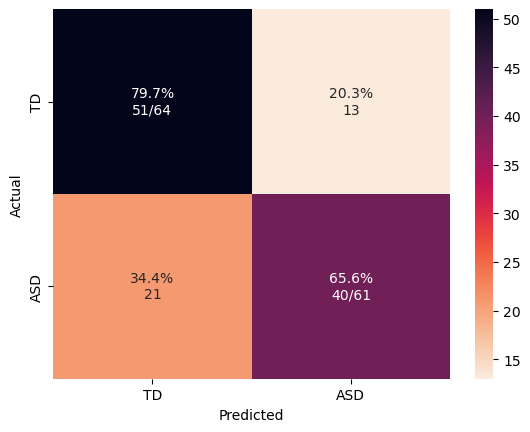

In [31]:
# Created by: Caroline Alves (https://github.com/Carol180619) # Modified 

print('CONFUSION MATRIX')
list_names=['TD','ASD']

cm = confusion_matrix(y_test, predictions)
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)
cm = pd.DataFrame(cm)
   # print(cm)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
#fig, ax = plt.subplots(figsize=figsize)
sns.heatmap(cm, annot=annot, fmt='',cmap='rocket_r',xticklabels=list_names, yticklabels=list_names)
#plt.savefig("CM/confusion-matrix-mlp.pdf",dpi=300, bbox_inches = "tight")